# Import Dependencies

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import skew
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set seaborn style
sns.set_style("whitegrid")

# Simulating a Dataset

In [66]:
# Set seed for reproducibility
np.random.seed(42)

# Number of records
num_samples = 5000
num_anomalies = 2500  # 50% anomalies

# African Countries for file-sharing access
african_countries = [
    "Nigeria", "South Africa", "Kenya", "Egypt", "Ghana", "Ethiopia", "Morocco", "Tanzania", "Algeria", "Uganda"
]

# Device Types
devices = ["Desktop", "Mobile", "Tablet"]

# File Types
file_types = ["PDF", "Image", "Video", "ZIP", "Executable"]

# Normal User Activity
data = []
for _ in range(num_samples - num_anomalies):
    user = f"user_{np.random.randint(1, 501)}"
    access_time = np.random.randint(7, 21)  # Work hours (7 AM - 9 PM)
    file_size = np.random.exponential(scale=5)  # Small file sizes
    network_latency = np.random.normal(loc=50, scale=15)  # Normal latency (ms)
    country = np.random.choice(african_countries, p=[0.2, 0.15, 0.1, 0.15, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05])
    num_files_transferred = np.random.randint(1, 15)  # Reasonable file transfers
    device_type = np.random.choice(devices)
    file_type = np.random.choice(file_types)
    login_failures = np.random.randint(0, 2)  # Few login failures
    ip_suspicion_score = np.random.uniform(0, 0.3)  # Low risk
    session_duration = np.random.randint(5, 60)  # Normal session times (minutes)
    data.append([user, access_time, file_size, network_latency, country, num_files_transferred,
                 device_type, file_type, login_failures, ip_suspicion_score, session_duration, 0])  # 0 = Normal

# Anomalous User Activity
for _ in range(num_anomalies):
    user = f"user_{np.random.randint(1, 501)}"
    access_time = np.random.randint(0, 24)  # Any time (including midnight)
    file_size = np.random.exponential(scale=50)  # Large file sizes
    network_latency = np.random.normal(loc=200, scale=50)  # High latency (potential attack)
    country = np.random.choice(african_countries)
    num_files_transferred = np.random.randint(50, 200)  # Suspiciously high transfers
    device_type = np.random.choice(devices)
    file_type = np.random.choice(file_types)
    login_failures = np.random.randint(3, 10)  # High login failures (brute force attack)
    ip_suspicion_score = np.random.uniform(0.7, 1.0)  # High-risk IPs
    session_duration = np.random.randint(1, 5)  # Short sessions (possible hacking attempts)
    data.append([user, access_time, file_size, network_latency, country, num_files_transferred,
                 device_type, file_type, login_failures, ip_suspicion_score, session_duration, 1])  # 1 = Anomalous

# Convert to DataFrame
columns = ["User", "Access Time", "File Size (MB)", "Network Latency (ms)", "Country",
           "Files Transferred", "Device Type", "File Type", "Login Failures",
           "IP Suspicion Score", "Session Duration (min)", "Anomaly"]
df = pd.DataFrame(data, columns=columns)

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=["Country", "Device Type", "File Type"], drop_first=True)

# Save dataset to CSV
df.to_csv("./dataset/anomaly_detection_dataset.csv", index=False)

# Show first few rows
df.head()

,User,Access Time,File Size (MB),Network Latency (ms),Files Transferred,Login Failures,IP Suspicion Score,Session Duration (min),Anomaly,Country_Egypt,...,Country_Nigeria,Country_South Africa,Country_Tanzania,Country_Uganda,Device Type_Mobile,Device Type_Tablet,File Type_Image,File Type_PDF,File Type_Video,File Type_ZIP
0,user_103,10,15.050607,59.715328,3,0,0.259853,40,0,False,...,True,False,False,False,False,True,False,False,True,False
1,user_360,14,5.261819,72.845448,8,1,0.297663,37,0,False,...,True,False,False,False,True,False,True,False,False,False
2,user_460,16,3.719639,24.126233,10,1,0.154270,7,0,False,...,False,False,False,False,False,True,False,False,True,False
3,user_485,9,5.701979,41.565687,2,1,0.242519,13,0,True,...,False,False,False,False,False,False,False,False,False,True
4,user_346,11,1.312631,61.687890,8,1,0.117318,54,0,False,...,False,False,False,False,False,True,False,False,True,False


# Data Preprocessing

## Checking skewness

Skewness measures the asymmetry of the data distribution. If a feature is highly skewed, it can impact the performance of machine learning models, especially those sensitive to outliers like Isolation Forest


🔹 Initial Skewness of Each Feature:
 Access Time              -0.250686
File Size (MB)            2.728018
Network Latency (ms)      0.423049
Files Transferred         0.548450
Login Failures            0.512380
IP Suspicion Score        0.001903
Session Duration (min)    0.859168
dtype: float64

✅ Fixed Skewness of Each Feature:
 Access Time              -0.250686
File Size (MB)            0.218681
Network Latency (ms)      0.423049
Files Transferred         0.548450
Login Failures            0.512380
IP Suspicion Score        0.001903
Session Duration (min)    0.859168
dtype: float64


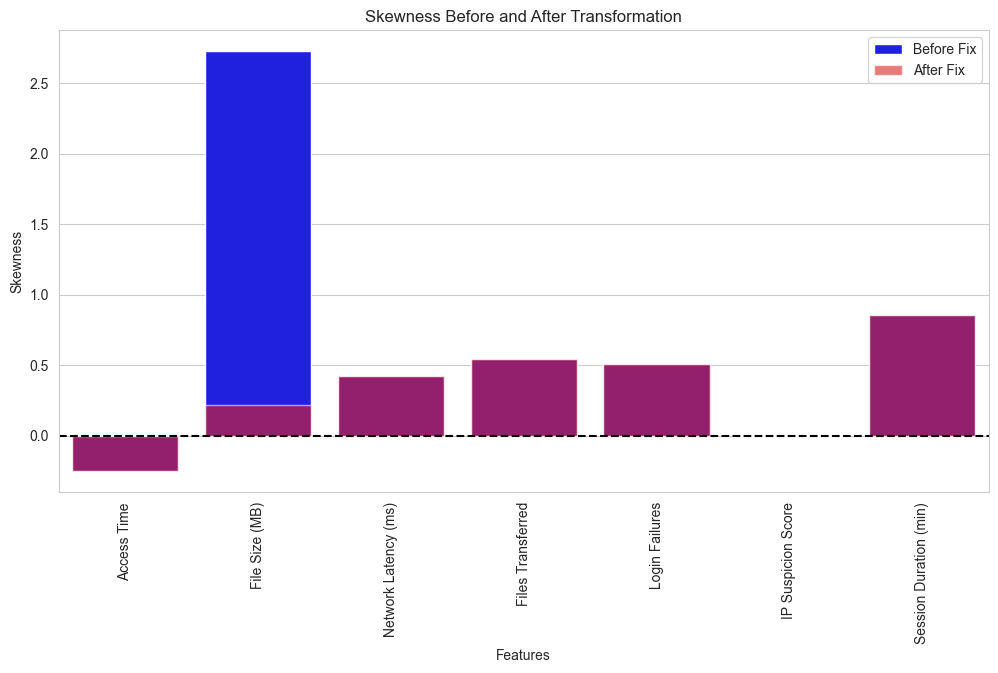

In [67]:
# Load Dataset
df = pd.read_csv("./dataset/anomaly_detection_dataset.csv")

# Separate Features and Target
X = df.drop(columns=["User", "Anomaly"])
y = df["Anomaly"]

# Select Only Numerical Features (Ignore Binary/Categorical)
numerical_columns = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numerical_columns]

# Compute Initial Skewness
initial_skew = X_numeric.apply(skew)
print("\n🔹 Initial Skewness of Each Feature:\n", initial_skew)

# Function to Fix Skewness
def fix_skewness(column):
    col_skew = skew(column)
    if col_skew > 1:  # Right-skewed (Apply log transformation)
        return np.log1p(column)
    elif col_skew < -1:  # Left-skewed (Apply square root transformation)
        return np.sqrt(np.abs(column))
    else:
        return column  # Keep unchanged if skewness is acceptable

# Apply Fix Only to Skewed Features
X_transformed = X_numeric.apply(fix_skewness)

# Compute Skewness After Transformation
fixed_skew = X_transformed.apply(skew)
print("\n✅ Fixed Skewness of Each Feature:\n", fixed_skew)

# Visualize Skewness Before & After
plt.figure(figsize=(12, 6))
sns.barplot(x=initial_skew.index, y=initial_skew.values, color="blue", label="Before Fix")
sns.barplot(x=fixed_skew.index, y=fixed_skew.values, color="red", alpha=0.6, label="After Fix")
plt.axhline(y=0, color='black', linestyle='dashed')  # Reference line for symmetry
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Skewness")
plt.title("Skewness Before and After Transformation")
plt.legend()
plt.show()

# 🚀 Merge Transformed Data Back (Keep Categorical Features)
X_final = X.copy()
X_final[numerical_columns] = X_transformed

# Train, Test Data

In [68]:
# 🚀 Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# 🚀 Standardize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_full_scaled = scaler.transform(X_final)

# Model Training -> Isolation forest

In [69]:
# Define parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],   # Number of trees
    "contamination": [0.02, 0.05, 0.1],  # Outlier percentage
    "max_samples": [256, 512, "auto"],  # Subsample size
    "max_features": [0.5, 1.0]  # Number of features per tree
}

# Perform Grid Search
iso_forest = IsolationForest(random_state=42)
grid_search = GridSearchCV(iso_forest, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train best model
iso_forest = IsolationForest(**best_params, random_state=42)
iso_forest.fit(X_train_scaled)

# 🚀 Make Predictions
y_train_pred = iso_forest.predict(X_train_scaled)
y_test_pred = iso_forest.predict(X_test_scaled)

# 🚀 Convert Predictions (-1 = anomaly, 1 = normal)
y_train_pred = np.where(y_train_pred == -1, 1, 0)
y_test_pred = np.where(y_test_pred == -1, 1, 0)

# 🚀 Predict Anomalies on Full Dataset
df["Predicted_Anomaly"] = iso_forest.predict(X_full_scaled)
df["Predicted_Anomaly"] = df["Predicted_Anomaly"].apply(lambda x: 1 if x == -1 else 0)



Best Parameters: {'contamination': 0.02, 'max_features': 1.0, 'max_samples': 256, 'n_estimators': 50}


# Save model and predictions

In [70]:

# Save trained model
joblib.dump(iso_forest, "./model/isolation_forest_model.pkl")
print("Model saved as 'isolation_forest_model.pkl'.")

# Save predictions to CSV
df.to_csv("./dataset/anomaly_predictions.csv", index=False)
print("Predictions saved as 'anomaly_predictions.csv'.")


Model saved as 'isolation_forest_model.pkl'.
Predictions saved as 'anomaly_predictions.csv'.


# Scatter Plot Visualizations

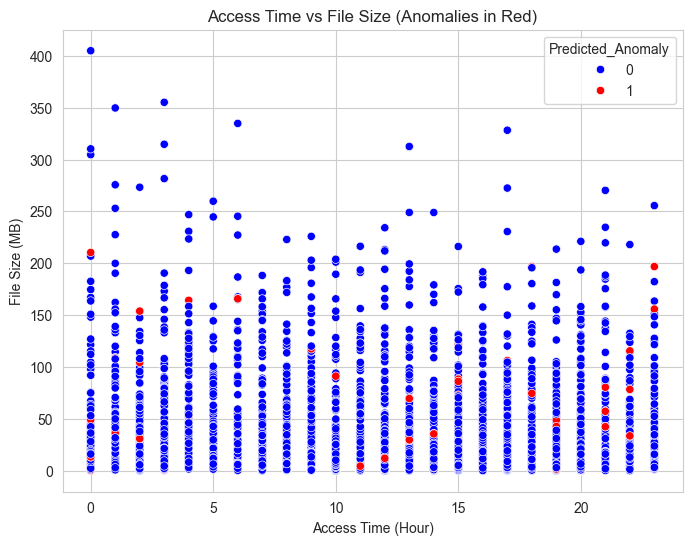

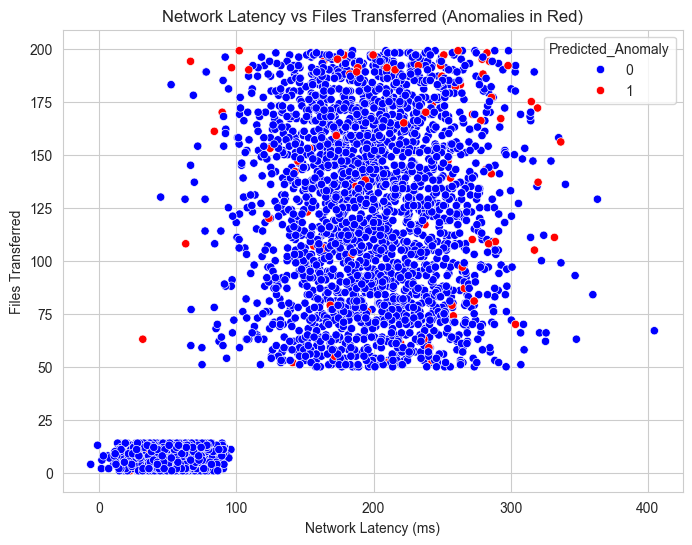

In [71]:
# Scatter plot: Access Time vs File Size
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["Access Time"], y=df["File Size (MB)"], hue=df["Predicted_Anomaly"], palette={0: "blue", 1: "red"})
plt.title("Access Time vs File Size (Anomalies in Red)")
plt.xlabel("Access Time (Hour)")
plt.ylabel("File Size (MB)")
plt.show()


# Scatter plot: Network Latency vs Files Transferred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["Network Latency (ms)"], y=df["Files Transferred"], hue=df["Predicted_Anomaly"], palette={0: "blue", 1: "red"})
plt.title("Network Latency vs Files Transferred (Anomalies in Red)")
plt.xlabel("Network Latency (ms)")
plt.ylabel("Files Transferred")
plt.show()

# Final Prediction Visualization


Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.99      0.67      2500
           1       0.85      0.03      0.07      2500

    accuracy                           0.51      5000
   macro avg       0.68      0.51      0.37      5000
weighted avg       0.68      0.51      0.37      5000


Confusion Matrix:
 [[2485   15]
 [2413   87]]


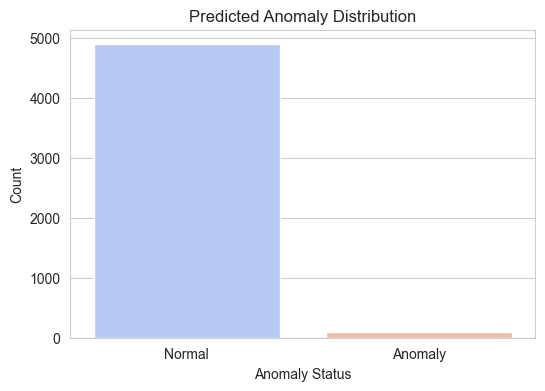


Top 5 Detected Anomalies:

         User  Access Time  File Size (MB)  Network Latency (ms)  \
71   user_107           19        0.012992             37.719845   
94    user_92           16        0.357059             45.060894   
249  user_478           12       17.172097             30.752339   
314  user_492           18        2.513716             36.490689   
895  user_297           13        0.245105             55.893703   

     Files Transferred  Login Failures  IP Suspicion Score  \
71                   8               0            0.295877   
94                   4               0            0.260969   
249                  9               0            0.145608   
314                 12               0            0.017428   
895                  1               0            0.243131   

     Session Duration (min)  Anomaly  Country_Egypt  ...  \
71                       51        0          False  ...   
94                       59        0          False  ...   
249       

In [72]:
# Classification Report
print("\nClassification Report:\n", classification_report(df["Anomaly"], df["Predicted_Anomaly"]))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(df["Anomaly"], df["Predicted_Anomaly"]))

# Countplot of Predicted Anomalies
plt.figure(figsize=(6, 4))
sns.countplot(x="Predicted_Anomaly", data=df, palette="coolwarm", hue="Predicted_Anomaly", legend=False)
plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.title("Predicted Anomaly Distribution")
plt.xlabel("Anomaly Status")
plt.ylabel("Count")
plt.show()

# Show Detected Anomalies
anomalies_detected = df[df["Predicted_Anomaly"] == 1]
print("\nTop 5 Detected Anomalies:\n")
print(anomalies_detected.head())

# Save anomaly report
anomalies_detected.to_csv("./dataset/detected_anomalies.csv", index=False)
print("Detected anomalies saved as 'detected_anomalies.csv'.")
